In [61]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import jaccard_score

In [62]:
np.random.seed(93)

In [63]:
csv_path = '/Users/elizabethnemeti/Desktop/masks-dataset/train.csv'
df = pd.read_csv(csv_path)

images_base_dir = '/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train'
masks_base_dir = '/Users/elizabethnemeti/Desktop/masks-dataset/png/uw-madison-gi-tract-image-segmentation/train'

In [64]:
def is_valid_image_mask_pair(image_path, mask_path):
    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        return False
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path)
    
    if image is None or mask is None:
        return False

    combined_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
    combined_mask[mask[:, :, 0] > 0] = 1  # Large bowel
    combined_mask[mask[:, :, 1] > 0] = 2  # Small bowel
    combined_mask[mask[:, :, 2] > 0] = 3  # Stomach

    # each mask has at least one positive pixel?
    if not (np.any(combined_mask == 1) and np.any(combined_mask == 2) and np.any(combined_mask == 3)):
        return False

    return True

print("Collecting valid image-mask pairs...")
max_images = 2000
valid_count = 0
images = []
masks = []

for index, row in df.iterrows():
    if valid_count >= max_images:
        break
    
    image_relative_path = os.path.relpath(row['image_path'], '/kaggle/input/uw-madison-gi-tract-image-segmentation/train')
    image_path = os.path.join(images_base_dir, image_relative_path)
    mask_relative_path = os.path.relpath(row['mask_path'], '/kaggle/input/uwmgi-mask-dataset/png/uw-madison-gi-tract-image-segmentation/train')
    mask_path = os.path.join(masks_base_dir, mask_relative_path)
    
    if is_valid_image_mask_pair(image_path, mask_path):
        valid_count += 1
        images.append(image_path)
        masks.append(mask_path)
        print(f"Processed {valid_count} valid pairs so far...")

print(f"Total valid image-mask pairs collected: {valid_count}")

Processed 1 valid pairs so far...
Processed 2 valid pairs so far...
Processed 3 valid pairs so far...
Processed 4 valid pairs so far...
Processed 5 valid pairs so far...
Processed 6 valid pairs so far...
Processed 7 valid pairs so far...
Processed 8 valid pairs so far...
Processed 9 valid pairs so far...
Processed 10 valid pairs so far...
Processed 11 valid pairs so far...
Processed 12 valid pairs so far...
Processed 13 valid pairs so far...
Processed 14 valid pairs so far...
Processed 15 valid pairs so far...
Processed 16 valid pairs so far...
Processed 17 valid pairs so far...
Processed 18 valid pairs so far...
Processed 19 valid pairs so far...
Processed 20 valid pairs so far...
Processed 21 valid pairs so far...
Processed 22 valid pairs so far...
Processed 23 valid pairs so far...
Processed 24 valid pairs so far...
Processed 25 valid pairs so far...
Processed 26 valid pairs so far...
Processed 27 valid pairs so far...
Processed 28 valid pairs so far...
Processed 29 valid pairs so f

### PRINTS ALL IMAGES ###

# Function to overlay masks on the image and display the result
def display_image_with_mask(image_path, mask_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalize the image to improve visibility
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    # Load the mask image
    mask = cv2.imread(mask_path)

    # Check if mask is loaded correctly
    if mask is None:
        return

    # Split the mask into individual channels
    large_bowel_mask = mask[:,:,0]
    small_bowel_mask = mask[:,:,1]
    stomach_mask = mask[:,:,2]

    # Check if all three masks contain non-zero values
    if not (np.any(large_bowel_mask) and np.any(small_bowel_mask) and np.any(stomach_mask)):
        return

    # Create color masks
    large_bowel_color = np.zeros_like(mask)
    small_bowel_color = np.zeros_like(mask)
    stomach_color = np.zeros_like(mask)

    large_bowel_color[:,:,1] = large_bowel_mask  # Green channel for large bowel
    small_bowel_color[:,:,2] = small_bowel_mask  # Blue channel for small bowel
    stomach_color[:,:,0] = stomach_mask  # Red channel for stomach

    # Overlay masks on the original image
    overlay_large_bowel = cv2.addWeighted(cv2.merge([image, image, image]), 0.7, large_bowel_color, 0.3, 0)
    overlay_small_bowel = cv2.addWeighted(cv2.merge([image, image, image]), 0.7, small_bowel_color, 0.3, 0)
    overlay_stomach = cv2.addWeighted(cv2.merge([image, image, image]), 0.7, stomach_color, 0.3, 0)

    # Combine all masks into one overlay
    combined_masks = cv2.addWeighted(large_bowel_color, 0.3, small_bowel_color, 0.3, 0)
    combined_masks = cv2.addWeighted(combined_masks, 1, stomach_color, 0.3, 0)
    overlay_all = cv2.addWeighted(cv2.merge([image, image, image]), 0.7, combined_masks, 0.3, 0)

    # Display the image and masks
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 5, 1)
    plt.title('Image')
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.title('Large Bowel Mask Overlay')
    plt.imshow(overlay_large_bowel)
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.title('Small Bowel Mask Overlay')
    plt.imshow(overlay_small_bowel)
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.title('Stomach Mask Overlay')
    plt.imshow(overlay_stomach)
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.title('All Masks Overlay')
    plt.imshow(overlay_all)
    plt.axis('off')

    plt.show()

# Iterate over the entries in the dataframe
for index, row in df.iterrows():
    # Construct full image path
    image_relative_path = os.path.relpath(row['image_path'], '/kaggle/input/uw-madison-gi-tract-image-segmentation/train')
    image_path = os.path.join(images_base_dir, image_relative_path)

    # Construct full mask path
    mask_relative_path = os.path.relpath(row['mask_path'], '/kaggle/input/uwmgi-mask-dataset/png/uw-madison-gi-tract-image-segmentation/train')
    mask_path = os.path.join(masks_base_dir, mask_relative_path)

    if os.path.exists(image_path) and os.path.exists(mask_path):
        display_image_with_mask(image_path, mask_path)

Normalize images

In [65]:
def normalize_image(image):
    # Normalize the image to the range 0-255
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return normalized_image

Feature Extraction

In [66]:
def extract_features(image):
    rows, cols = image.shape
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(grad_x, grad_y)
    angle = cv2.phase(grad_x, grad_y, angleInDegrees=True)
    
    gabor_kernels = [cv2.getGaborKernel((21, 21), 5, theta, 10, 0.5, 0, ktype=cv2.CV_32F) for theta in np.arange(0, np.pi, np.pi / 8)]
    gabor_features = [cv2.filter2D(image, cv2.CV_8UC3, kernel).flatten() for kernel in gabor_kernels]
    
    features = np.array([[r, c, image[r, c], magnitude[r, c], angle[r, c]] + [gabor[r * cols + c] for gabor in gabor_features] for r in range(rows) for c in range(cols)])
    return features
    
# extract labels here
def extract_labels(mask):
    large_bowel_mask = mask[:,:,0]
    small_bowel_mask = mask[:,:,1]
    stomach_mask = mask[:,:,2]
    
    labels = np.zeros(large_bowel_mask.size, dtype=int)
    labels[large_bowel_mask.flatten() > 0] = 1
    labels[small_bowel_mask.flatten() > 0] = 2
    labels[stomach_mask.flatten() > 0] = 3
    
    return labels
    
features_list = []
labels_list = []
subset_size = 50

print("Extracting features and labels from images and masks...")
sampled_df = df.sample(subset_size, random_state=30)
for index, row in sampled_df.iterrows():
    image_relative_path = os.path.relpath(row['image_path'], '/kaggle/input/uw-madison-gi-tract-image-segmentation/train')
    image_path = os.path.join(images_base_dir, image_relative_path)
    mask_relative_path = os.path.relpath(row['mask_path'], '/kaggle/input/uwmgi-mask-dataset/png/uw-madison-gi-tract-image-segmentation/train')
    mask_path = os.path.join(masks_base_dir, mask_relative_path)

    if os.path.exists(image_path) and os.path.exists(mask_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path)
        
        if mask is None:
            continue

        image = normalize_image(image)
        large_bowel_mask = mask[:,:,0]
        small_bowel_mask = mask[:,:,1]
        stomach_mask = mask[:,:,2]

        if not (np.any(large_bowel_mask) and np.any(small_bowel_mask) and np.any(stomach_mask)):
            continue
        
        features = extract_features(image)
        labels = extract_labels(mask)
        
        features_list.append(features)
        labels_list.append(labels)

features = np.vstack(features_list)
labels = np.hstack(labels_list)

print(f"Total features: {features.shape}")
print(f"Total labels: {labels.shape}")

Extracting features and labels from images and masks...
Total features: (141512, 13)
Total labels: (141512,)


Data Splitting

In [67]:
print("Data splitting...")
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=30)
print("Data split done")

Data splitting...
Data split done


Grid Search for the best parameters using cross-validation

print("Finding best kernel...")
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy')
grid_search.fit(features_train, labels_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}, with Cross-Validation Score: {best_score}")

print("Training SVM classifier...")
svc = SVC(**best_params)
svc.fit(features_train, labels_train)
print("Model training completed")

Train with just RBF

svc = SVC(kernel='rbf', C=1, gamma='scale')
svc.fit(features_train, labels_train)

Trying Poly kernel

In [68]:
svc = SVC(kernel='poly', degree=3, C=1, gamma='scale', coef0=0)  # Adjust parameters as needed
svc.fit(features_train, labels_train)

SVC(C=1, coef0=0, kernel='poly')

print("Saving images to folder...")
output_folder = '/Users/elizabethnemeti/Desktop/svm_results'
os.makedirs(output_folder, exist_ok=True)

In [69]:
# Predict and evaluate the model
labels_pred = svc.predict(features_test)
accuracy = accuracy_score(labels_test, labels_pred)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.94


In [70]:
# Classification Report
print("Classification Report:\n", classification_report(labels_test, labels_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     26608
           1       1.00      0.00      0.01       912
           2       0.00      0.00      0.00       250
           3       0.80      0.13      0.23       533

    accuracy                           0.94     28303
   macro avg       0.68      0.28      0.30     28303
weighted avg       0.93      0.94      0.92     28303



/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [71]:
def predict_and_display(image_path, count, display=False):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = normalize_image(image)
    features = extract_features(image)
    predicted_labels = svc.predict(features)
    segmented_image = predicted_labels.reshape(image.shape)

    # Create color mask for overlay
    color_mask = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    color_mask[segmented_image == 1] = [0, 255, 0]  # Green for large bowel
    color_mask[segmented_image == 2] = [0, 0, 255]  # Blue for small bowel
    color_mask[segmented_image == 3] = [255, 0, 0]  # Red for stomach

    overlay = cv2.addWeighted(cv2.merge([image, image, image]), 0.7, color_mask, 0.3, 0)

    output_folder = '/Users/elizabethnemeti/Desktop/svm_results'
    os.makedirs(output_folder, exist_ok=True)
    output_file_path = os.path.join(output_folder, f'segmentation_{count}.png')
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Segmented Image')
    plt.imshow(overlay)
    plt.axis('off')

    plt.savefig(output_file_path, format='png')

    if display:
        plt.show()
    else:
        plt.close()

    # Clean up to free memory
    del image, features, predicted_labels, segmented_image, color_mask, overlay
    import gc
    gc.collect()

Predicting and displaying segmentation for new images...


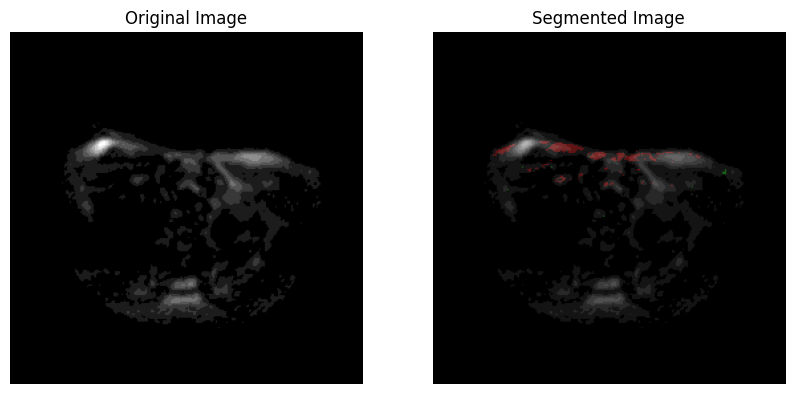

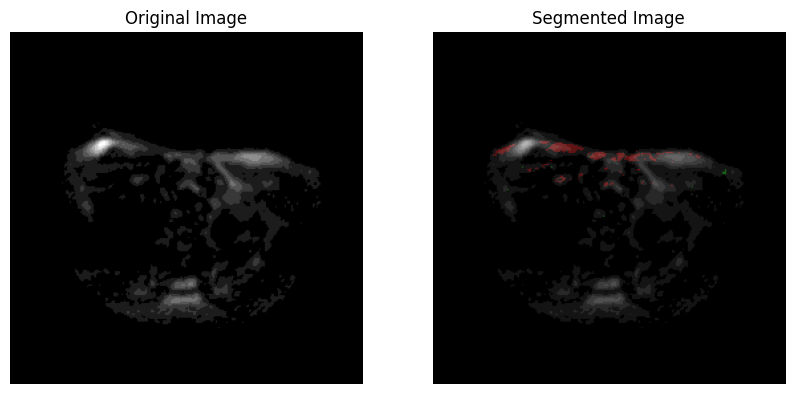

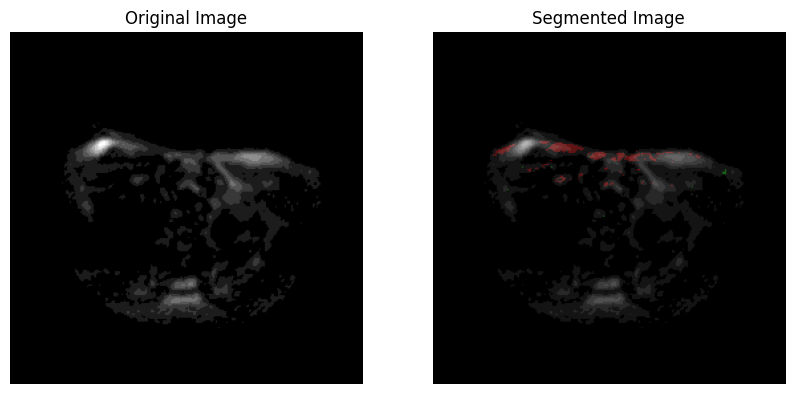

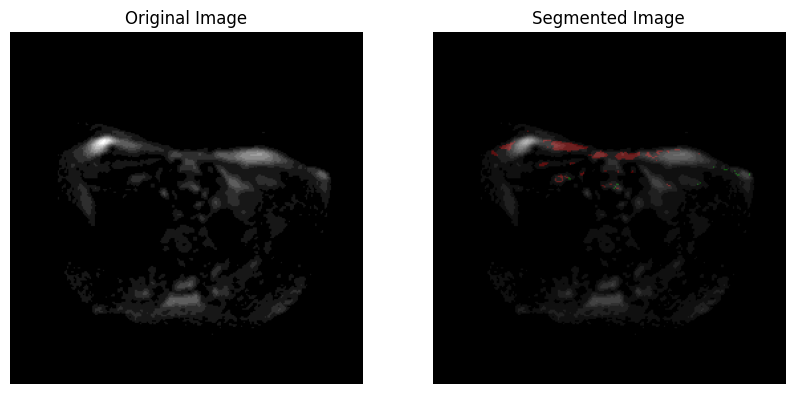

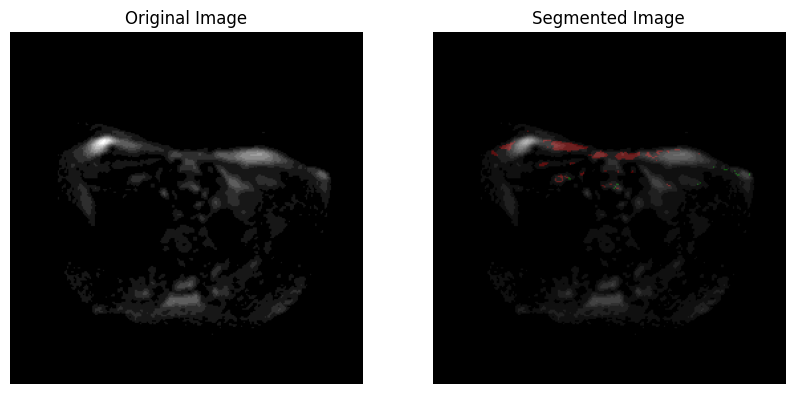

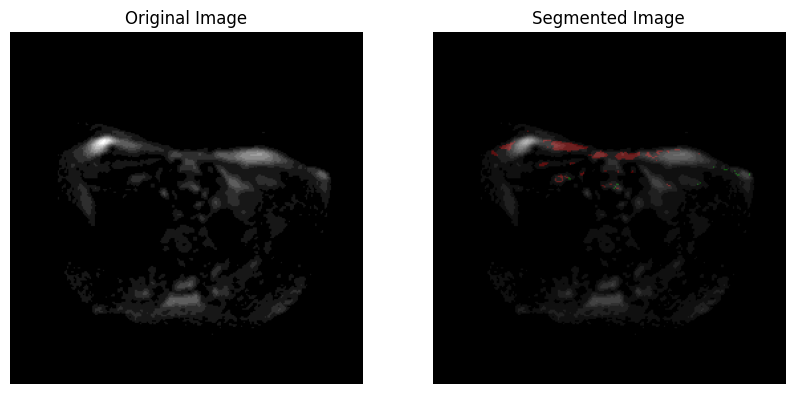

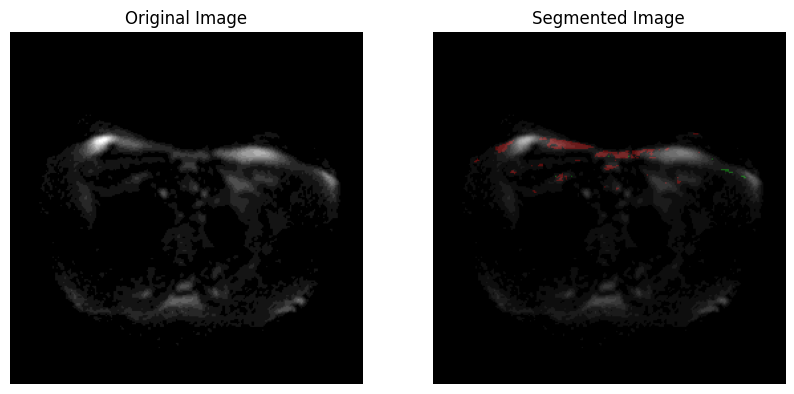

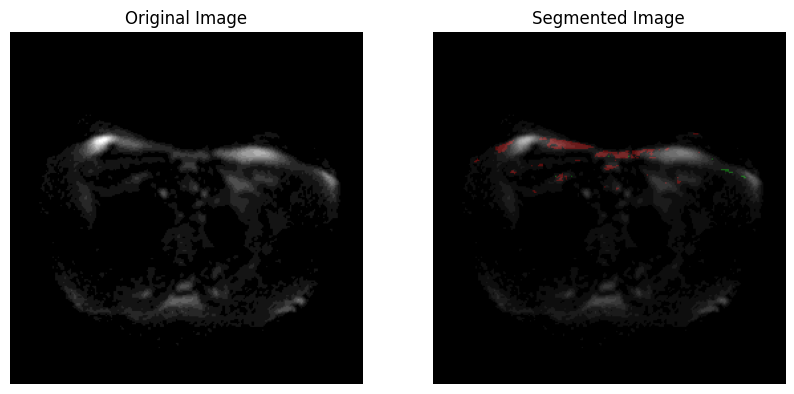

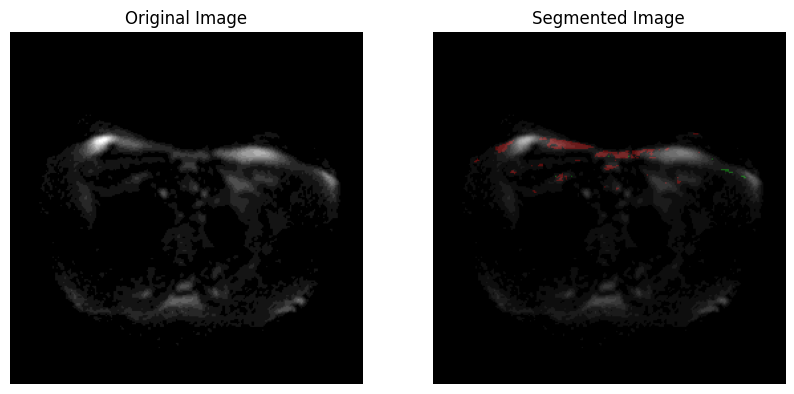

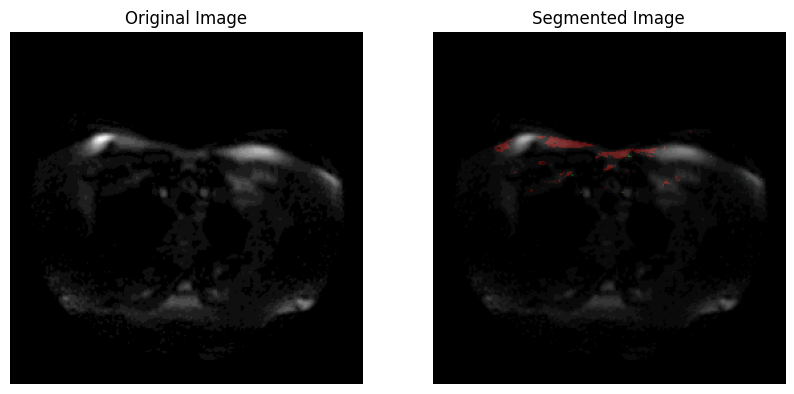

Segmentation process completed


In [72]:
count = 0
visualization_limit = 10  # 10 samples

print("Predicting and displaying segmentation for new images...")
for index, row in df.iterrows():
    if count >= visualization_limit:
        break

    # Construct full image path
    image_relative_path = os.path.relpath(row['image_path'], '/kaggle/input/uw-madison-gi-tract-image-segmentation/train')
    image_path = os.path.join(images_base_dir, image_relative_path)

    if os.path.exists(image_path):
        predict_and_display(image_path, count, display=(count < 10))  # Display the first 10 images
        count += 1

print("Segmentation process completed")

Testing